# Modelling via scikit-learn

This notebook performs model fitting and evaluating on hold out areas, using models from scikit-learn.

## Imports and Setup

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

## File Locations

In [2]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

## Load Data

In [3]:
# !gsutil cp gs://immap-wash-training/training/20200916_*.csv {data_dir}
df = pd.read_csv(data_dir + '20200916_dataset.csv')
df['population'] = df['population'].fillna(0)
df = df.dropna().reset_index(drop = True)
df.shape

(57036, 45)

## Check nulls and outliers

Total rows: 57036
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


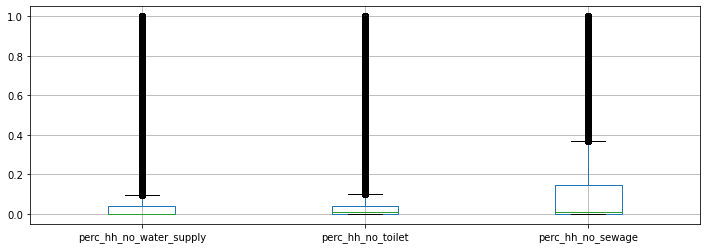

In [29]:
modelutils.check_nulls_and_outliers(df, columns = indicators)

Total rows: 57036
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


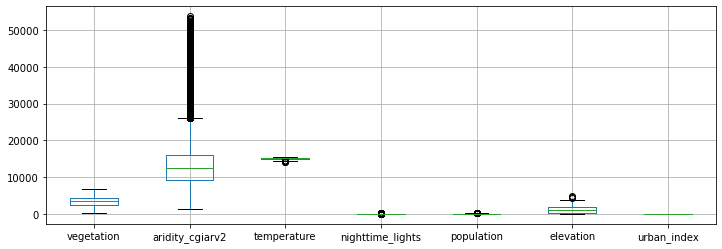

In [19]:
modelutils.check_nulls_and_outliers(df, columns = satellite_features)

Total rows: 57089
Variables with missing values:
Empty DataFrame
Columns: [count, mean, std, min, max]
Index: []


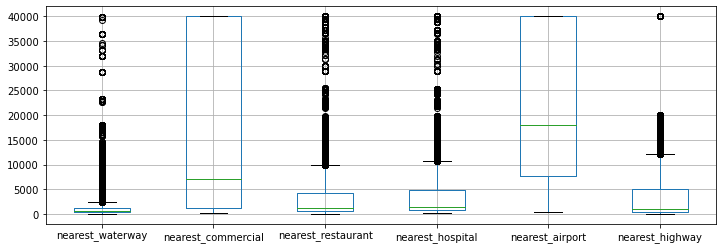

In [7]:
modelutils.check_nulls_and_outliers(df, columns = poi_features)

## Count rows with WASH value 0 (has access)

In [8]:
for urb_ in ['u', 'r']:
    print(f"Processing for urbanity = '{urb_}'")
    for indicator in indicators:
        print(indicator)
        print(sum(df.query(f"urbanity == '{urb_}'")[indicator]==0)/df.shape[0])

Processing for urbanity = 'u'
perc_hh_no_water_supply
0.43938411953265955
perc_hh_no_toilet
0.24209567517385136
perc_hh_no_sewage
0.31337035155634185
Processing for urbanity = 'r'
perc_hh_no_water_supply
0.036662053985881696
perc_hh_no_toilet
0.03244057524216574
perc_hh_no_sewage
0.03244057524216574


## Fit, Predict and Evaluate Models Using 5-fold Cross Validation
Trains a random forest model to predict each of the 3 WASH indicators, setting random 20% of the data (whichever the area) as test data and everything else as training data. The train-test split is done for 5 different folds.

### Using Both Urban and Rural Dataset

In [4]:
# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(random_state=42)

# res = modelutils.fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all_250mv2')
res = pd.read_csv(data_dir + 'all_250mv2_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'all_250mv2')

Access to water
correlation    0.772267
r2             0.596589
rmse           0.129155
dtype: float64
Access to toilet
correlation    0.731977
r2             0.535973
rmse           0.123311
dtype: float64
Access to sewage
correlation    0.804580
r2             0.647380
rmse           0.170705
dtype: float64


In [6]:
# clf = RandomForestRegressor(random_state=42)

# res = fit_with_randomsplit(df, clf, features, indicators, scale = True, n_splits = 5, prefix = 'all')
res = pd.read_csv(data_dir + 'all_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'all')

Access to water
correlation    0.772267
r2             0.596589
rmse           0.129155
dtype: float64
Access to toilet
correlation    0.731977
r2             0.535973
rmse           0.123311
dtype: float64
Access to sewage
correlation    0.804580
r2             0.647380
rmse           0.170705
dtype: float64


In [10]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.6215550756716262

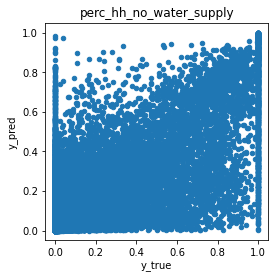

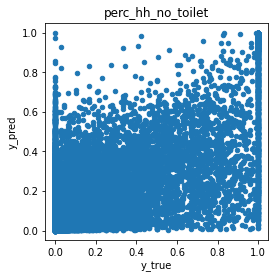

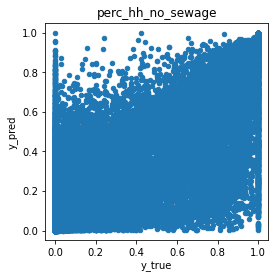

In [11]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))

### Using Urban Only

In [23]:
sub = df.query("urbanity == 'u'").reset_index(drop = True)
print(sub.shape)
clf = RandomForestRegressor(random_state=42)

res = modelutils.fit_with_randomsplit(sub, clf, features, indicators, scale = True, n_splits = 5, prefix = 'urban')
res = pd.read_csv(data_dir + 'urban_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'urban')

Access to water
correlation    0.778704
r2             0.606417
rmse           0.108150
dtype: float64
Access to toilet
correlation    0.624664
r2             0.390369
rmse           0.087399
dtype: float64
Access to sewage
correlation    0.818808
r2             0.670459
rmse           0.152473
dtype: float64


In [24]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.6379135705617788

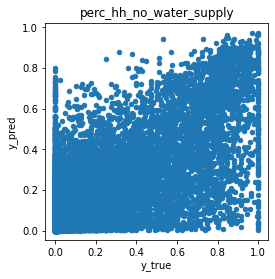

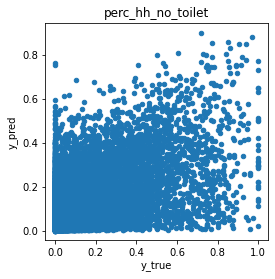

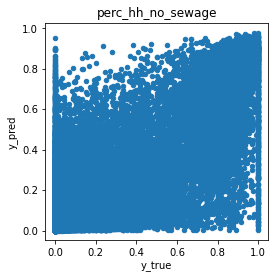

In [25]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))

### Using Rural Only

In [28]:
sub = df.query("urbanity == 'r'").reset_index(drop = True)
print(sub.shape)
clf = RandomForestRegressor(random_state=42)

res = modelutils.fit_with_randomsplit(sub, clf, features, indicators, scale = True, n_splits = 5, prefix = 'rural')
res = pd.read_csv(data_dir + 'rural_randomsplit_results.csv')
modelutils.average_results(res, iterate_over = 'split_id', prefix = 'rural')

  0%|          | 0/3 [00:00<?, ?it/s]

(4371, 45)


100%|██████████| 3/3 [00:46<00:00, 15.55s/it]

Access to water
correlation    0.704082
r2             0.496195
rmse           0.267631
dtype: float64
Access to toilet
correlation    0.701241
r2             0.491999
rmse           0.298694
dtype: float64
Access to sewage
correlation    0.701241
r2             0.491999
rmse           0.298694
dtype: float64


In [29]:
pearsonr(res['y_true'], res['y_pred'])[0]**2

0.4999225598641761

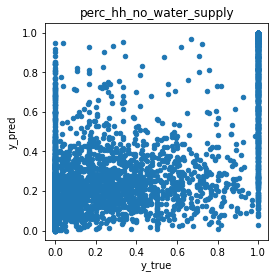

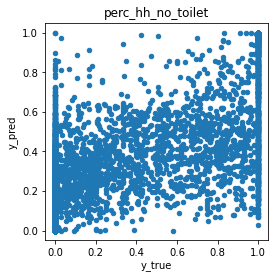

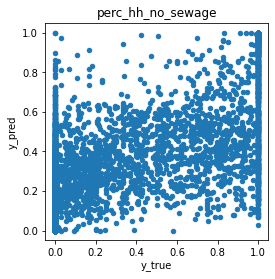

In [30]:
for indicator in indicators:
    (res.query(f"indicator == '{indicator}'")
     .plot(x = 'y_true', y = 'y_pred', figsize = (4,4), kind = 'scatter', title = indicator))